# Chapter 6

In [1]:
import numpy as np
from collections import defaultdict
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## Example 6.2 with empircal test for exercise 6.3 and 6.4

In [2]:
class DPAgent():
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
    '''
    def __init__(self, states, actions, transition_table, discount_factor):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        # start with stochastic policy
        self.policy = {}
        for state in states:
            self.policy[state] = [(action, 1/len(self.actions[state])) for action in self.actions[state]]
        self.V = defaultdict(lambda : 0)
        self.discount_factor = discount_factor
    
    def evaluate_policy(self, threshold, verbose=False):
        while True:
            delta = 0
            oldV = copy.deepcopy(self.V)
            for state in self.states:
                v = self.V[state]
                newV = 0
                for action, prob in self.policy[state]:
                    for transition, next_state, reward in self.transition_table[(state, action)]:
                        newV += prob * transition * (reward + self.discount_factor * oldV[next_state])
                self.V[state] = newV
                delta = max(delta, abs(v - self.V[state]))
            if verbose:
                print(self.V)
            if delta < threshold:
                break
                
    def improve_policy(self):
        did_change = False
        for state in self.states:
            best_action = None
            best_value = -1000
            for action in self.actions[state]:
                action_value = 0
                for transition, next_state, reward in self.transition_table[(state, action)]:
                    action_value += transition * (reward + self.discount_factor * self.V[next_state])
                    if action_value > best_value:
                        best_action = action
                        best_value = action_value
            newPolicy = [(action, 1) if action == best_action else (action, 0) for action in self.actions[state]]
            if not all([na == oa and nv == ov for (na, nv), (oa, ov) in zip(newPolicy, self.policy[state])]):
                did_change = True
            self.policy[state] = newPolicy
        return did_change
            
                
    def iterate_policy(self):
        did_change = True
        while did_change:
            self.evaluate_policy(1e-10)
            did_change = self.improve_policy()
        

In [11]:
random_walk_states = range(6) # [a = 0, b= 1, ...] state 5 will be dummy state
random_walk_actions = defaultdict(lambda : ['l', 'r'])
random_walk_table = {}
for state in random_walk_states:
    for action in random_walk_actions[state]:
        if state == 4 and action == 'r':
            random_walk_table[state, action] = [(1, 5, 1)]
        elif state == 0 and action == 'l':
            random_walk_table[state, action] = [(1, 5, 0)]
        elif state == 5:
            random_walk_table[state, action] = [(1, 5, 0)]
        else:
            random_walk_table[state, action] = [(1, state + ( 1 if action == 'r' else -1), 0)]

In [15]:
random_walk_dp_agent = DPAgent(random_walk_states, random_walk_actions, random_walk_table, 1)

In [16]:
random_walk_dp_agent.evaluate_policy(1e-30)

In [17]:
random_walk_dp_agent.V

defaultdict(<function __main__.DPAgent.__init__.<locals>.<lambda>>,
            {0: 0.16666666666666663,
             1: 0.33333333333333326,
             2: 0.4999999999999999,
             3: 0.6666666666666665,
             4: 0.8333333333333333,
             5: 0.0})

In [19]:
actual_v = [random_walk_dp_agent.V[state] for state in range(5)]

In [31]:
class RandomWalk:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['l', 'r']
    
    def start(self):
        self.state = 2
        return self.state
    
    def act(self, action):
        if self.state == 0 and action == 'l':
            return 0, 0, True
        elif self.state == 4 and action == 'r':
            return 4, 1, True
        else:
            self.state += 1 if action == 'r' else -1
            return self.state, 0, False

In [32]:
random_walk_env = RandomWalk()

In [57]:
class TDAgent:
    def __init__(self, env, policy, alpha, discount=1, init_v = None):
        self.env = env
        self.policy = policy # is a function
        self.actions = env.actions
        self.V = defaultdict(lambda : init_v if init_v else 0)
        self.discount = discount
        self.alpha = alpha
        self.init_v = init_v
        
    def evaluate(self, episodes):
        for i in range(episodes):
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                if not is_end:
                    self.V[state] += self.alpha * (reward + self.discount * self.V[next_state] - self.V[state])
                else:
                    self.V[state] += self.alpha * (reward - self.V[state])
                state = next_state
                
    def reset(self):
        self.V = defaultdict(lambda : self.init_v if self.init_v else 0)

In [73]:
random_walk_td_agent = TDAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), 0.1, init_v=0.5)

In [74]:
td_v = {}

In [87]:
for i in [0, 1, 10, 100]:
    random_walk_td_agent.evaluate(i)
    td_v[i] = [random_walk_td_agent.V[state] for state in range(5)]
    random_walk_td_agent.reset()

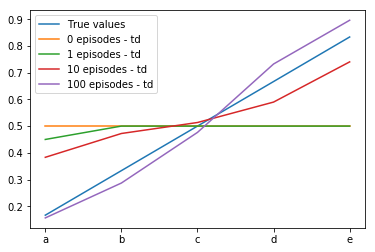

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(5), actual_v, label='True values')
ax.set_xticks(range(5))
ax.set_xticklabels(['a', 'b', 'c', 'd', 'e'])
for i in [0, 1,10,100]:
    ax.plot(range(5), td_v[i], label='%d episodes - td' %i)
plt.legend()

In [193]:
class MCAgent:
    def __init__(self, env, policy, alpha, discount=1, init_v = None):
        self.env = env
        self.policy = policy # is a function
        self.actions = env.actions
        self.V = defaultdict(lambda : init_v if init_v else 0)
        self.init_v = init_v
        self.returns = defaultdict(list)
        self.discount = discount
        self.alpha = alpha
    
    def evaluate_first_visit(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                if not state in G:
                    G[state] = 0
                    step_since_visit[state] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                state = next_state
            for state, g in G.items():
                self.V[state] += self.alpha * (g - self.V[state])
    
    # it turns out the book used every visit MC. If we use first-visit MC, the performance is better
    def evaluate(self, episodes):
        for i in range(episodes):
            state = self.env.start()
            is_end = False
            episode = []
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                episode.append((state, reward, next_state))
                state = next_state
            g = 0
            for state, reward, next_state in episode[::-1]:
                g = self.discount * g + reward
                self.V[state] += self.alpha * (g - self.V[state])
                
    def reset(self):
        self.V = defaultdict(lambda : self.init_v if self.init_v else 0)

In [204]:
td_rms = {}
for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
    
    errors = []
    for i in range(50): # do it 50 times
        agent = TDAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), alpha, init_v=0.5)
        squared_errors = []
        for j in range(100):
            agent.evaluate(1)
            v = [agent.V[state] for state in range(5)]
            squared_errors.append(np.square(np.array(v) - np.array(actual_v)))
        errors.append(squared_errors)
    
    td_rms[alpha] = np.mean(np.sqrt(np.mean(errors, axis=0)), axis=1)


mc_rms = {}
for alpha in [0.01, 0.02, 0.025, 0.03, 0.035, 0.04]:
    
    errors = []
    for i in range(50):
        agent = MCAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), alpha, init_v=0.5)
        squared_errors = []
        for j in range(100):
            agent.evaluate(1)
            v = [agent.V[state] for state in range(5)]
            squared_errors.append(np.square(np.array(v) - np.array(actual_v)))
        errors.append(squared_errors)
    mc_rms[alpha] = np.mean(np.sqrt(np.mean(errors, axis=0)), axis=1)


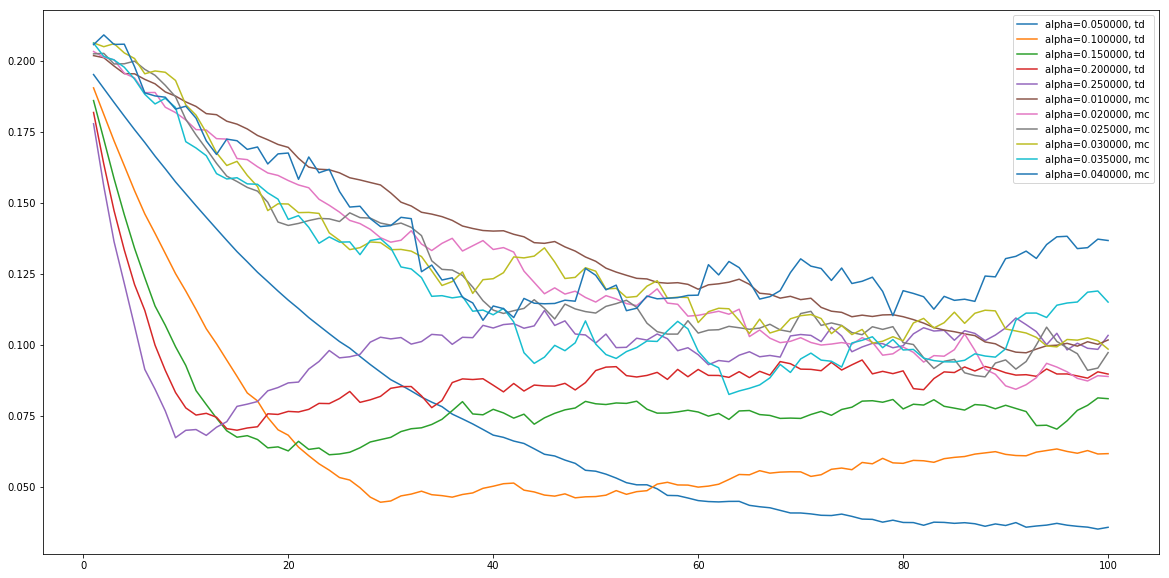

In [205]:
plt.figure(figsize=(20,10))
for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
    plt.plot(range(1,101), td_rms[alpha], label='alpha=%f, td' % alpha)
for alpha in [0.01, 0.02, 0.025, 0.03, 0.035, 0.04]:
    plt.plot(range(1,101), mc_rms[alpha], label='alpha=%f, mc' % alpha)
plt.legend()

I added more alpha value for MC to determine if it would affect our conclusion of whether MC or TD is better (exercise 6.3)

### Testing 6.4 empirically

In [180]:
errors = []
for i in range(100): # do it 100 times
    agent = TDAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), 0.15, init_v=0.5)
    agent.V = {0: 0.3, 1: 0.3, 2: 0.4, 3:0.6, 4:0.8}
    squared_errors = []
    for j in range(100):
        agent.evaluate(1)
        v = [agent.V[state] for state in range(5)]
        squared_errors.append(np.square(np.array(v) - np.array(actual_v)))
    errors.append(squared_errors)

rms = np.mean(np.sqrt(np.mean(errors, axis=0)), axis=1)

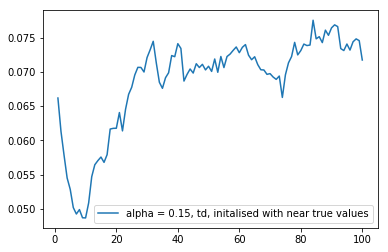

In [181]:
plt.plot(range(1,101), rms, label='alpha = 0.15, td, initalised with near true values')
plt.legend()

so it seems that when one initialised the value function close to its true value, the dip is still there

This suggests the dip and rise is due to the fact that a high alpha means the value function is too sensitive to noise, leading to high error after convergence. We can test this by initialising it with true values.

In [178]:
errors = []
for i in range(100): # do it 100 times
    agent = TDAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), 0.15, init_v=0.5)
    agent.V = {0: 1/6, 1: 2/6, 2: 3/6, 3:4/6, 4:5/6}
    squared_errors = []
    for j in range(100):
        agent.evaluate(1)
        v = [agent.V[state] for state in range(5)]
        squared_errors.append(np.square(np.array(v) - np.array(actual_v)))
    errors.append(squared_errors)

rms = np.mean(np.sqrt(np.mean(errors, axis=0)), axis=1)

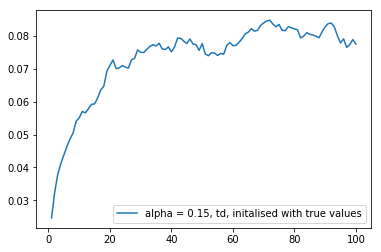

In [179]:
plt.plot(range(1,101), rms, label='alpha = 0.15, td, initalised with true values')
plt.legend()

Indeed, initialising it at true value, the error increase with each episode

In [184]:
errors = []
for i in range(100): # do it 100 times
    agent = TDAgent(random_walk_env, lambda _: np.random.choice(['l', 'r']), 0.15, init_v=0)
    squared_errors = []
    for j in range(200):
        agent.evaluate(1)
        v = [agent.V[state] for state in range(5)]
        squared_errors.append(np.square(np.array(v) - np.array(actual_v)))
    errors.append(squared_errors)

rms = np.mean(np.sqrt(np.mean(errors, axis=0)), axis=1)

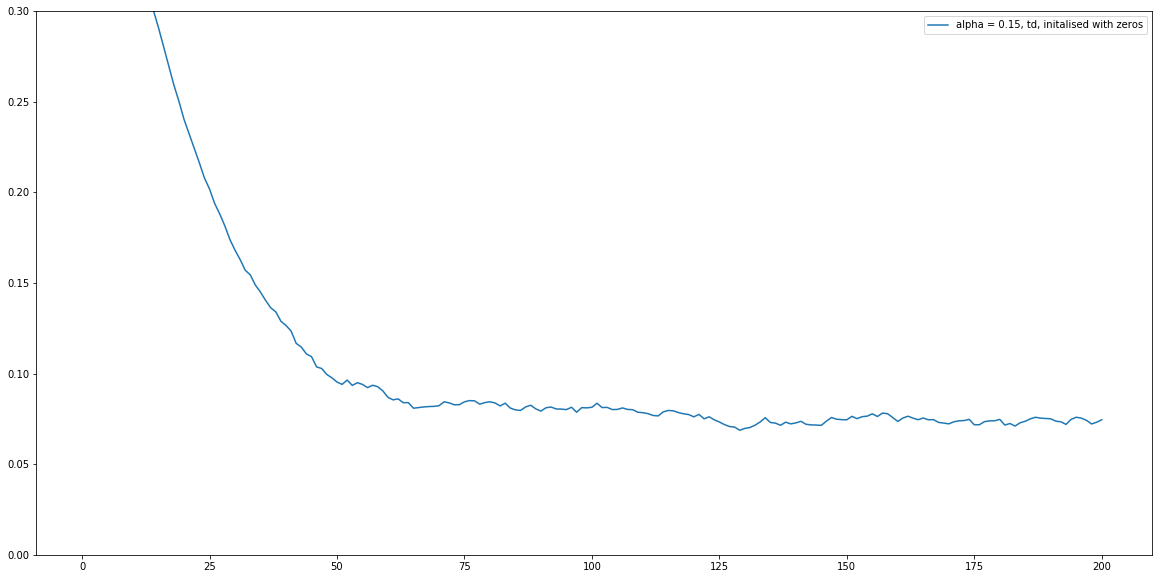

In [188]:
plt.figure(figsize=(20,10))
plt.plot(range(1,201), rms, label='alpha = 0.15, td, initalised with zeros')
plt.ylim(0, 0.3)
plt.legend()

Interestingly, initialising it with zeros eliminated the dip.

## Example 6.5 - windy gridworld

In [2]:
def rargmax(vector):
    """ Argmax that chooses randomly among eligible maximum indices. """
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return np.random.choice(indices)

class SarsaAgent:
    def __init__(self, env, alpha, epsilon, discount=1):
        self.env = env
        self.actions = env.actions
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = defaultdict(int)
        self.timestep = 0
        self.episode = 0
        self.stats = [(0,0)] # each state element is a tuple of (timestep, episode)
        self.episode_stats = [(0,0)] # each state element is a tuple of (episode, sum of reward)
    
    def select_action(self, state, e_greedy=True):
        if np.random.uniform() < self.epsilon and e_greedy:
            return np.random.choice(self.actions)
        else:
            best_action = None
            best_value = -1000000
            for action in self.actions:
                value = self.Q[state, action]
                if value > best_value:
                    best_action = action
                    best_value = value
                elif value == best_value:
                    # randomly decide to replace it
                    if np.random.uniform() < 0.5:
                        best_action = action
            return best_action

    def train(self, total_timesteps):
        state = self.env.start()
        action = self.select_action(state)
        total_reward = 0
        while self.timestep < total_timesteps: # total_timesteps is a global count
            next_state, reward, is_end = self.env.act(action)
            self.timestep += 1
            total_reward += reward
            if is_end:
                self.Q[state, action] += self.alpha * (reward - self.Q[state, action])
                state = self.env.start() # reset state for next episode
                action = self.select_action(state)
                self.episode += 1
                self.stats.append((self.timestep, self.episode))
                self.episode_stats.append((self.episode, total_reward))
                total_reward = 0
            else:
                next_action = self.select_action(next_state)
                self.Q[state, action] += self.alpha * \
                            (reward + self.discount * self.Q[next_state, next_action] - self.Q[state, action])
                state = next_state
                action = next_action
        self.stats.append((self.timestep, self.episode))
        
            
                    
                

In [203]:
class WindyGridworld:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    def __init__(self, with_kings_move=False, stochastic=False):
        if with_kings_move:
            self.actions = ['n', 's', 'e', 'w', 'nw', 'ne', 'sw', 'se']
        else:
            self.actions = ['n', 's', 'e', 'w']
        self.action_to_change = {'n': (0, 1), 's': (0, -1), 'e': (1, 0), 'w': (-1,0), \
                                 'nw':(-1,1), 'ne': (1,1), 'sw': (-1, -1), 'se': (1, -1)}
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.x_grid = 10
        self.y_grid = 7
        self.start_state = (0, 3)
        self.goal_state = (7, 3)
        self.with_kings_move = with_kings_move
        self.stochastic = stochastic
    
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        change = self.action_to_change[action]
        new_x = self.state[0] + change[0]
        new_x = min(self.x_grid-1, max(0, new_x))
        new_y = self.state[1] + change[1]
        new_y = min(self.y_grid-1, max(0, new_y))
        new_y += self.wind[self.state[0]] + (np.random.randint(-1,2) if self.stochastic and self.wind[self.state[0]] > 0 else 0)
        new_y = min(self.y_grid-1, max(0, new_y))
        self.state = (new_x, new_y)
        if self.state == self.goal_state:
            reward = 0
            is_end = True
        else:
            reward = -1
            is_end = False
        return self.state, reward, is_end

In [133]:
basic_windy_world = WindyGridworld(with_kings_move=False, stochastic=False)
basic_windy_agent = SarsaAgent(basic_windy_world, 0.5, 0.1, discount=1)

In [134]:
basic_windy_agent.train(8000)

In [3]:
# print sample trajectory
def print_trajectory(agent, env):
    state = env.start()
    trajectory = [(state[0] + 0.5, state[1] + 0.5)]
    is_end = False
    while not is_end:
        state, _, is_end = env.act(agent.select_action(state, e_greedy=False))
        trajectory.append((state[0] + 0.5, state[1] + 0.5))
    return trajectory

In [145]:
x, y = zip(*print_trajectory(basic_windy_agent, basic_windy_world))

Text(7.5,3.5,'G')

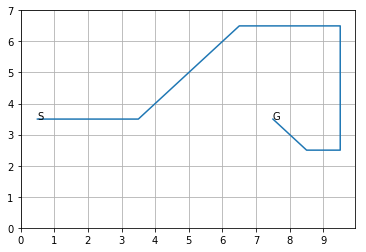

In [156]:
plt.plot(x, y)
plt.ylim(0,7)
plt.xticks(range(10))
plt.grid()
plt.text(0.5, 3.5, "S")
plt.text(7.5, 3.5, "G")

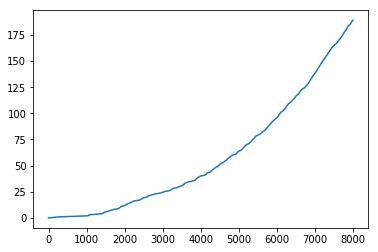

In [166]:
plt.plot(*zip(*basic_windy_agent.stats))

## Exercise 6.7

In [157]:
king_windy_world = WindyGridworld(with_kings_move=True, stochastic=False)
king_windy_agent = SarsaAgent(king_windy_world, 0.5, 0.1, discount=1)

In [167]:
king_windy_agent.train(100000)

Text(7.5,3.5,'G')

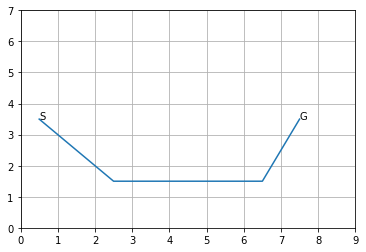

In [168]:
x, y = zip(*print_trajectory(king_windy_agent, king_windy_world))
plt.plot(x, y)
plt.ylim(0,7)
plt.xticks(range(10))
plt.grid()
plt.text(0.5, 3.5, "S")
plt.text(7.5, 3.5, "G")

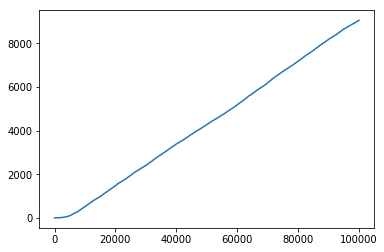

In [169]:
plt.plot(*zip(*king_windy_agent.stats))

## Exercise 6.8

In [204]:
stochastic_windy_world = WindyGridworld(with_kings_move=True, stochastic=True)
stochastic_windy_agent = SarsaAgent(stochastic_windy_world, 0.5, 0.1, discount=1)

In [213]:
stochastic_windy_agent.train(1000000)

Text(7.5,3.5,'G')

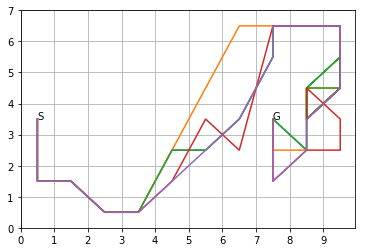

In [219]:
for i in range(5):
    x, y = zip(*print_trajectory(stochastic_windy_agent, stochastic_windy_world))
    plt.plot(x, y)
plt.ylim(0,7)
plt.xticks(range(10))
plt.grid()
plt.text(0.5, 3.5, "S")
plt.text(7.5, 3.5, "G")

## Example 6.6 - Cliff

In [4]:
class Cliff:
    actions = ['u', 'd', 'l', 'r']
    start_state = (0,0)
    goal_state = (11, 0)
    x_size = 12
    y_size = 4
    
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if action == 'u':
            next_state = self.state[0], min(self.state[1] + 1, self.y_size-1)
        elif action == 'd':
            next_state = self.state[0], max(self.state[1] -1, 0)
        elif action == 'r':
            next_state = min(self.state[0] + 1, self.x_size - 1), self.state[1]
        elif action == 'l':
            next_state = max(self.state[0] - 1, 0), self.state[1]
        is_end = False
        if next_state == self.goal_state:
            is_end = True
            reward = 0
        elif next_state[1] == 0 and next_state[0] > 0 and next_state[0] < 11:
            reward = -100
            next_state = self.start_state
        else:
            reward = -1
        self.state = next_state
        return self.state, reward, is_end

In [94]:
class QLearningAgent:
    def __init__(self, env, alpha, epsilon, discount=1):
        self.env = env
        self.actions = env.actions
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = defaultdict(int)
        self.episode = 0
        self.stats = [(0,0)] # each state element is a tuple of (episode, sum of reward)
        self.action_stats = [] # each state element is a dict of action taken in state
        
    def select_action(self, state, e_greedy=True):
        actions = self.actions(state) if callable(self.actions) else self.actions
        if np.random.uniform() < self.epsilon and e_greedy:
            return np.random.choice(actions)
        else:
            best_action = None
            best_value = -1000000
            for action in actions:
                value = self.Q[state, action]
                if value > best_value:
                    best_action = action
                    best_value = value
                elif value == best_value:
                    # randomly decide to replace it
                    if np.random.uniform() < 0.5:
                        best_action = action
            return best_action
        
    def train(self, episodes):
        while self.episode < episodes:
            state = self.env.start()
            is_end = False
            total_reward = 0
            action_stats = defaultdict(lambda : defaultdict(int))
            while not is_end:
                action = self.select_action(state)
                action_stats[state][action] += 1
                next_state, reward, is_end = self.env.act(action)
                total_reward += reward
                if is_end:
                    self.Q[state, action] += self.alpha * (reward - self.Q[state, action])
                else:
                    actions = self.actions(next_state) if callable(self.actions) else self.actions
                    self.Q[state, action] += self.alpha * (reward + self.discount * max([self.Q[next_state, action] for action in actions]) - self.Q[state, action])
                state = next_state  
            self.episode += 1
            self.stats.append((self.episode, total_reward))
            self.action_stats.append(action_stats)

In [52]:
cliff_env = Cliff()
cliff_qagent = QLearningAgent(cliff_env, 0.1, 0.1)
cliff_qagent.train(500)

In [27]:
cliff_sarsa_agent = SarsaAgent(cliff_env, 0.1, 0.1)
while cliff_sarsa_agent.episode < 500:
    cliff_sarsa_agent.train(cliff_sarsa_agent.timestep + 50)

In [28]:
cliff_sarsa_agent.episode

502

(-200, 0)

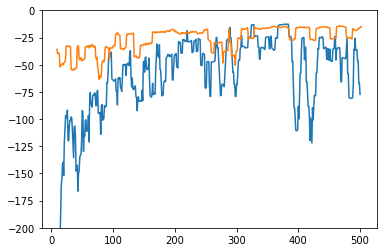

In [34]:
x, y = zip(*cliff_qagent.stats)
y = np.convolve(y, np.ones((10,))/10, mode='valid')
plt.plot(x[9:], y)
x, y = zip(*cliff_sarsa_agent.episode_stats)
y = np.convolve(y, np.ones((10,))/10, mode='valid')
plt.plot(x[9:], y)
plt.ylim(-200, 0)

# I am not sure why my sum of rewards fluctuates more than the graph given in the book

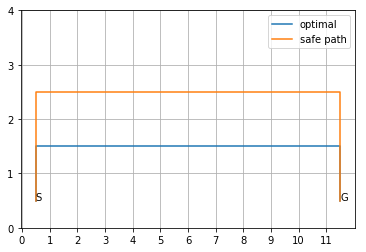

In [35]:
x, y = zip(*print_trajectory(cliff_qagent, cliff_env))
plt.plot(x, y, label="optimal")
x, y = zip(*print_trajectory(cliff_sarsa_agent, cliff_env))
plt.plot(x, y, label="safe path")
plt.ylim(0,3)
plt.yticks(range(5))
plt.xticks(range(12))
plt.grid()
plt.text(0.5, 0.5, "S")
plt.text(11.5, 0.5, "G")
plt.legend()

## Example 6.7

In [115]:
class BiasedEnv:
    start_state = 'A'
    
    def __init__(self):
        self.actions = lambda state: ['l', 'r'] if state == 'A' else range(10)
    
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if self.state == 'A':
            if action == 'r':
                return None, 0, True
            else:
                self.state = 'B'
                return self.state, 0, False
        else:
            return None, np.random.normal(loc=-0.1, scale=1), True

In [116]:
biased_env = BiasedEnv()

In [117]:
stats = []
for i in range(1000):
    biased_env_agent = QLearningAgent(biased_env, 0.1, 0.1)
    biased_env_agent.train(300)
    stat = [actions['A']['l']/(actions['A']['l'] + actions['A']['r']) for actions in biased_env_agent.action_stats]
    stats.append(stat)

In [121]:
class DQLearningAgent:
    def __init__(self, env, alpha, epsilon, discount=1):
        self.env = env
        self.actions = env.actions
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q1 = defaultdict(int)
        self.Q2 = defaultdict(int)
        self.episode = 0
        self.stats = [(0,0)] # each state element is a tuple of (episode, sum of reward)
        self.action_stats = [] # each state element is a dict of action taken in state
        
    def select_action(self, state, e_greedy=True):
        actions = self.actions(state) if callable(self.actions) else self.actions
        if np.random.uniform() < self.epsilon and e_greedy:
            return np.random.choice(actions)
        else:
            best_action = None
            best_value = -1000000
            for action in actions:
                value = self.Q1[state, action] + self.Q2[state, action]
                if value > best_value:
                    best_action = action
                    best_value = value
                elif value == best_value:
                    # randomly decide to replace it
                    if np.random.uniform() < 0.5:
                        best_action = action
            return best_action
        
    def train(self, episodes):
        while self.episode < episodes:
            state = self.env.start()
            is_end = False
            total_reward = 0
            action_stats = defaultdict(lambda : defaultdict(int))
            while not is_end:
                action = self.select_action(state)
                action_stats[state][action] += 1
                next_state, reward, is_end = self.env.act(action)
                total_reward += reward
                if np.random.uniform() < 0.5:
                    Q = self.Q1
                    Q_target = self.Q2
                else:
                    Q = self.Q2
                    Q_target = self.Q1
                if is_end:
                    Q[state, action] += self.alpha * (reward - Q_target[state, action])
                else:
                    actions = self.actions(next_state) if callable(self.actions) else self.actions
                    Q[state, action] += self.alpha * (reward + self.discount * Q_target[next_state, np.argmax([Q[next_state, action] for action in actions])] - Q[state, action])
                state = next_state  
            self.episode += 1
            self.stats.append((self.episode, total_reward))
            self.action_stats.append(action_stats)

In [122]:
dstats = []
for i in range(1000):
    biased_env_agent = DQLearningAgent(biased_env, 0.1, 0.1)
    biased_env_agent.train(300)
    stat = [actions['A']['l']/(actions['A']['l'] + actions['A']['r']) for actions in biased_env_agent.action_stats]
    dstats.append(stat)

Text(0.5,1,'Figure 6.8')

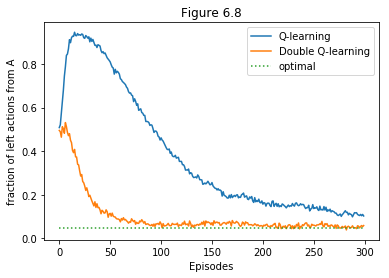

In [128]:
plt.plot(range(300), np.mean(stats, axis=0), label='Q-learning')
plt.plot(range(300), np.mean(dstats, axis=0), label='Double Q-learning')
plt.plot(range(300), [0.05] * 300, label='optimal', linestyle=':')
plt.legend()
plt.ylabel('fraction of left actions from A')
plt.xlabel('Episodes')
plt.title('Figure 6.8')